# ANALYSE DES SENTIMENTS AU TRAVERS D'UN TWEET

#### Nom: NGUAZONG TSAFACK 
#### Prénom: Aurel B.
#### Classe: AIA-4
#### Matricule: 20P001 

# I.Subtask A

## 1. Importation des données

In [65]:
#importer les bibliothèques

import pandas as pd
import numpy as np
from pathlib import Path

import seaborn as sns
import matplotlib.pyplot as plt
from plotly import graph_objs as go

import nltk
from nltk.corpus import stopwords
import string
from string import punctuation
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import PCA


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

import scipy

import re
import warnings
from tqdm import tqdm
%matplotlib inline


In [2]:
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', 100)



In [3]:
#importer les fichiers .tsv

tsv_path = list(Path('New_data/Subtask_A').glob("*.tsv"))
for path in tsv_path:
    print(f"{path.stem}.tsv")

twitter-2013dev-A.tsv
twitter-2013test-A.tsv
twitter-2013train-A.tsv
twitter-2014sarcasm-A.tsv
twitter-2014test-A.tsv
twitter-2015test-A.tsv
twitter-2015train-A.tsv
twitter-2016dev-A.tsv
twitter-2016devtest-A.tsv
twitter-2016test-A.tsv
twitter-2016train-A.tsv


### Concatenation des datasets

In [4]:
# création d'une dataset vide
df_subtask_A = pd.DataFrame()

In [5]:
# Remplissage de la dataset vide
for i in  range(len(tsv_path)):
    csv_table=pd.read_table(tsv_path[i],sep='\t', header=None)
    csv_table.to_csv('new_subtask_A.csv', header=None)

    if len(csv_table.columns) == 4:
        csv_table.columns = ["id", "label", "content", "inc"]
        csv_table = csv_table.loc[:, csv_table.columns[:-1]]
    else:
        csv_table.columns = ["id", "label", "content"]
    
    df_subtask_A = pd.concat([df_subtask_A, csv_table], axis=0) 

In [6]:
df_subtask_A.head()

,id,label,content
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s an...
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with ev...
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New...
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\...


## 2. Exploration et prétraitement des données

### 2.1. Exploration des données

In [7]:
df_subtask_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50132 entries, 0 to 5867
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50132 non-null  int64 
 1   label    50132 non-null  object
 2   content  50132 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


L'on remarque dans ce cas qu'il n'y a pas de données maquantes

In [8]:
#Vérification de valeurs duppliquées
df_subtask_A.duplicated().sum()

665

In [9]:
#Suppression des valeurs duppliquées
df_subtask_A.drop_duplicates(keep='first', inplace=True)
df_subtask_A.duplicated().sum()

0

In [9]:
df_subtask_A.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50132 entries, 0 to 5867
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       50132 non-null  int64 
 1   label    50132 non-null  object
 2   content  50132 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


In [11]:
df_subtask_A.label.value_counts()

label
neutral     22524
positive    19799
negative     7809
Name: count, dtype: int64

### 2.2. Prétraitement des données

#### Nétoyage des données et suppression des stopwords

In [12]:
data = df_subtask_A.copy()

In [14]:
my_stopword = ["tomorrow", "may", "time", "monday", "friday", "sunday"]
stuff_to_be_removed = list(stopwords.words('english'))+list(punctuation) + my_stopword
stemmer = LancasterStemmer()

corpus = data['content'].tolist()
print(len(corpus))
print(corpus[0])

50132
Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s and debates. Gulp. Debates...


In [24]:

def trait_text(text):

    #Removes unicode strings like "\u002c"  
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       

    #Convert to lowercase
    text = text.lower()
    
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub('_;__', '', text)
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," ",text)
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)


    ##Convert to list from string
    text = text.split()

    #Stemmatisation
    ps = nltk.PorterStemmer()
    text = [ps.stem(word) for word in text if not word in stuff_to_be_removed] 
    text = " ".join(text)
    return text

CPU times: total: 0 ns
Wall time: 0 ns


In [25]:
data["cleaned_content"] = data["content"].apply(lambda x: trait_text(x))
data.head()

,id,label,content,cleaned_content
0,260097528899452929,neutral,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s an...,match getin plu busi day awar day debat gulp debat
1,263791921753882624,neutral,Some areas of New England could see the first flakes of the season Tuesday.,area new england could see first flake season tuesday
2,264194578381410304,negative,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with ev...,worst qb definit toni romo man like share ball everyon includ team
3,264041328420204544,neutral,#Thailand Washington - US President Barack Obama vowed Wednesday as he visited storm-ravaged New...,thailand washington us presid barack obama vow wednesday visit storm ravag new jersey shore
4,263816256640126976,neutral,Did y\u2019all hear what Tony Romo dressed up as for Halloween? A Giants quaterback! Cause that\...,yll hear toni romo dress halloween giant quaterback caus that could throw night


## 3. Visualisation des données

### 3.1. Analyse uni-variée

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 49467 entries, 0 to 5867
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       49467 non-null  int64 
 1   label    49467 non-null  object
 2   content  49467 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.5+ MB


Text(0.5, 1.0, 'Distribution des sentiments: negative, positive et neutral')

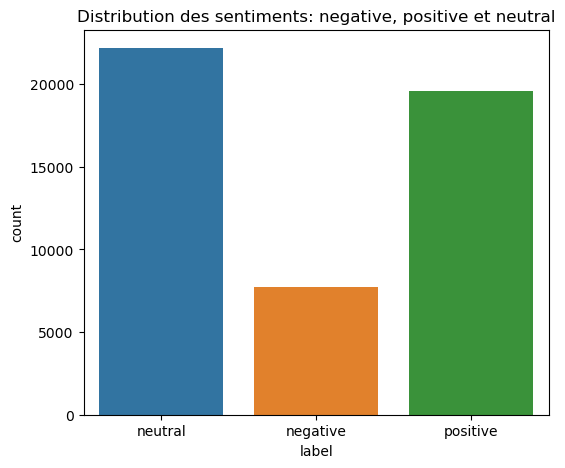

In [36]:
plt.figure(figsize=(6, 5))
sns.countplot(data=data, x="label" )
plt.title("Distribution des sentiments: negative, positive et neutral")

### 3.2. Visualisation des mots

In [26]:
#Extraction des mots positifs, negatifs et neutres
positive = data[data['label'] == "positive"]
positive_list = positive['cleaned_content'].tolist()
positive_all = ' '.join(positive_list)

negative = data[data['label'] == "negative"]
negative_list = negative['cleaned_content'].tolist()
negative_all = ' '.join(negative_list)

neutral = data[data['label'] == "neutral"]
neutral_list = neutral['cleaned_content'].tolist()
neutral_all = ' '.join(neutral_list)

print(len(positive_all))
print(len(negative_all))
print(len(neutral_all))

1265795
515057
1446355


**Word Cloud Visualisation**

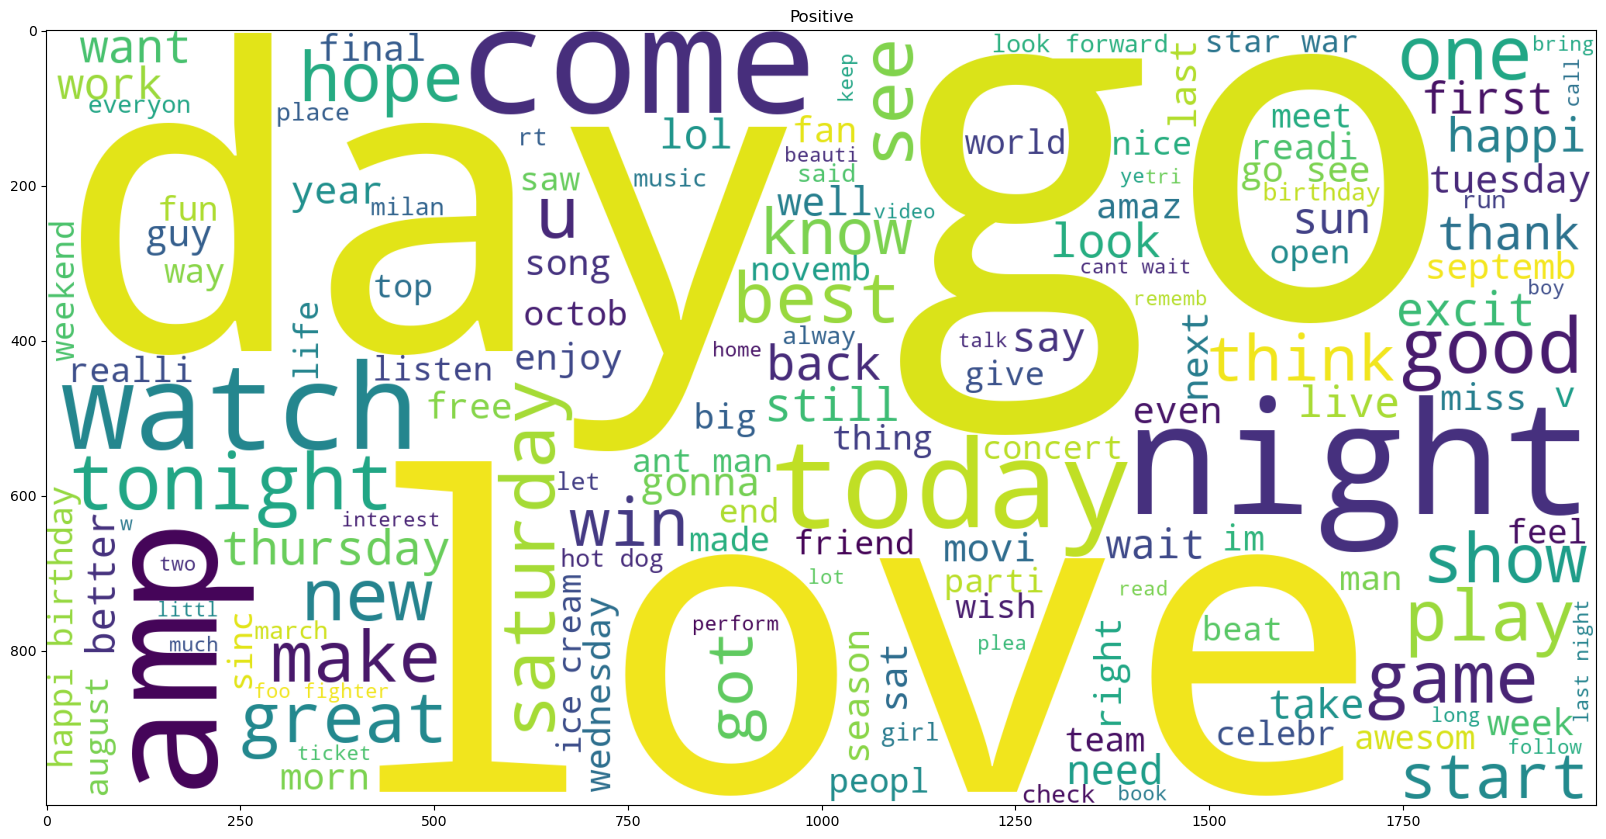

In [29]:
#Positive data
from wordcloud import WordCloud
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='white',
                      max_words = 150).generate(positive_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("Positive")
plt.show()

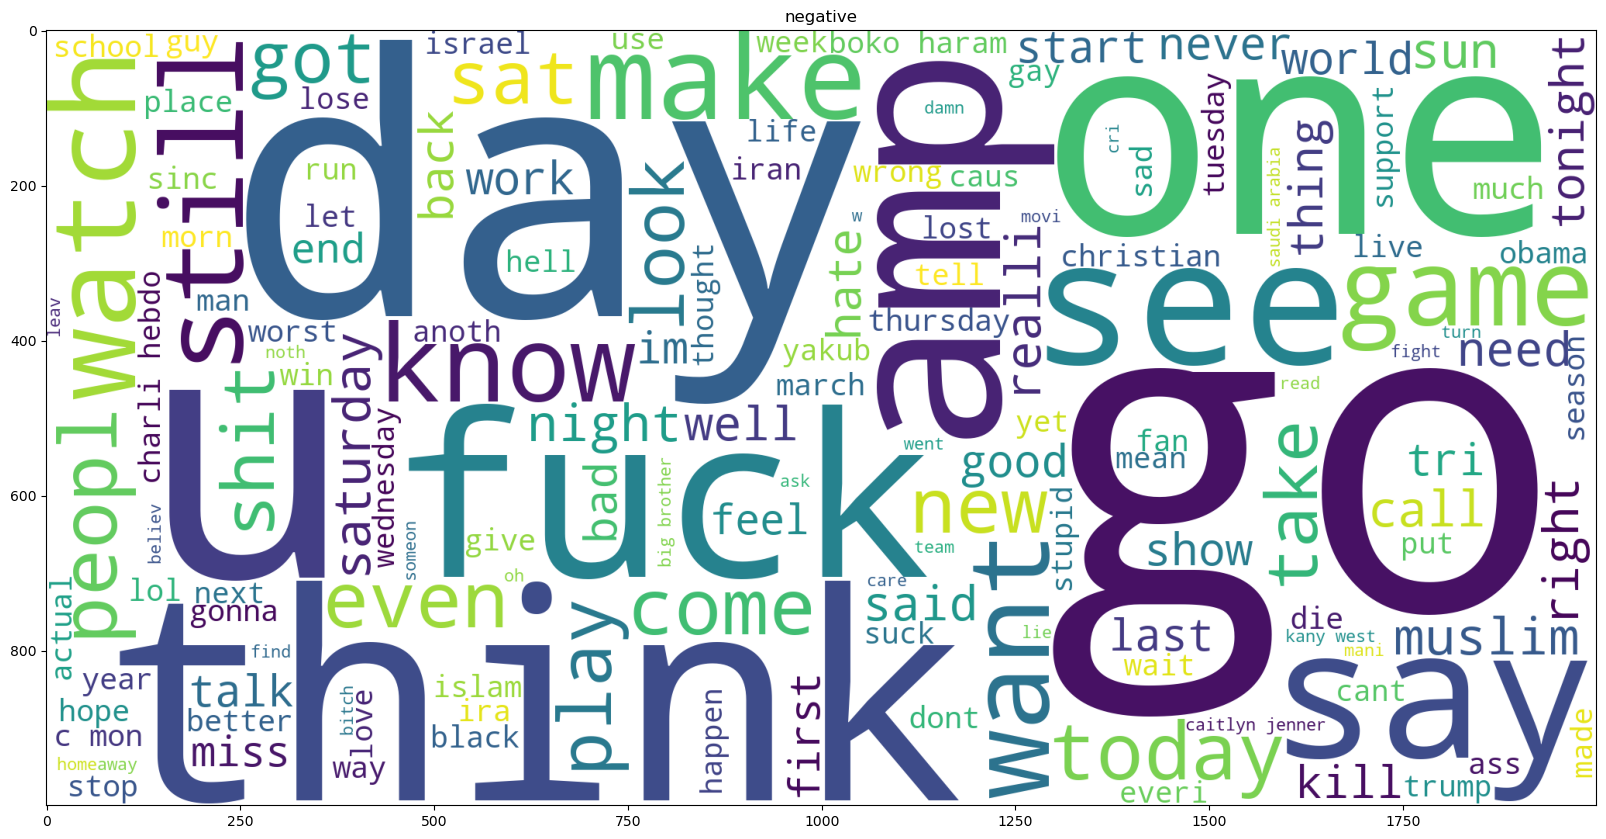

In [30]:
#Negative data
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='white',
                      max_words = 150).generate(negative_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("negative")
plt.show()

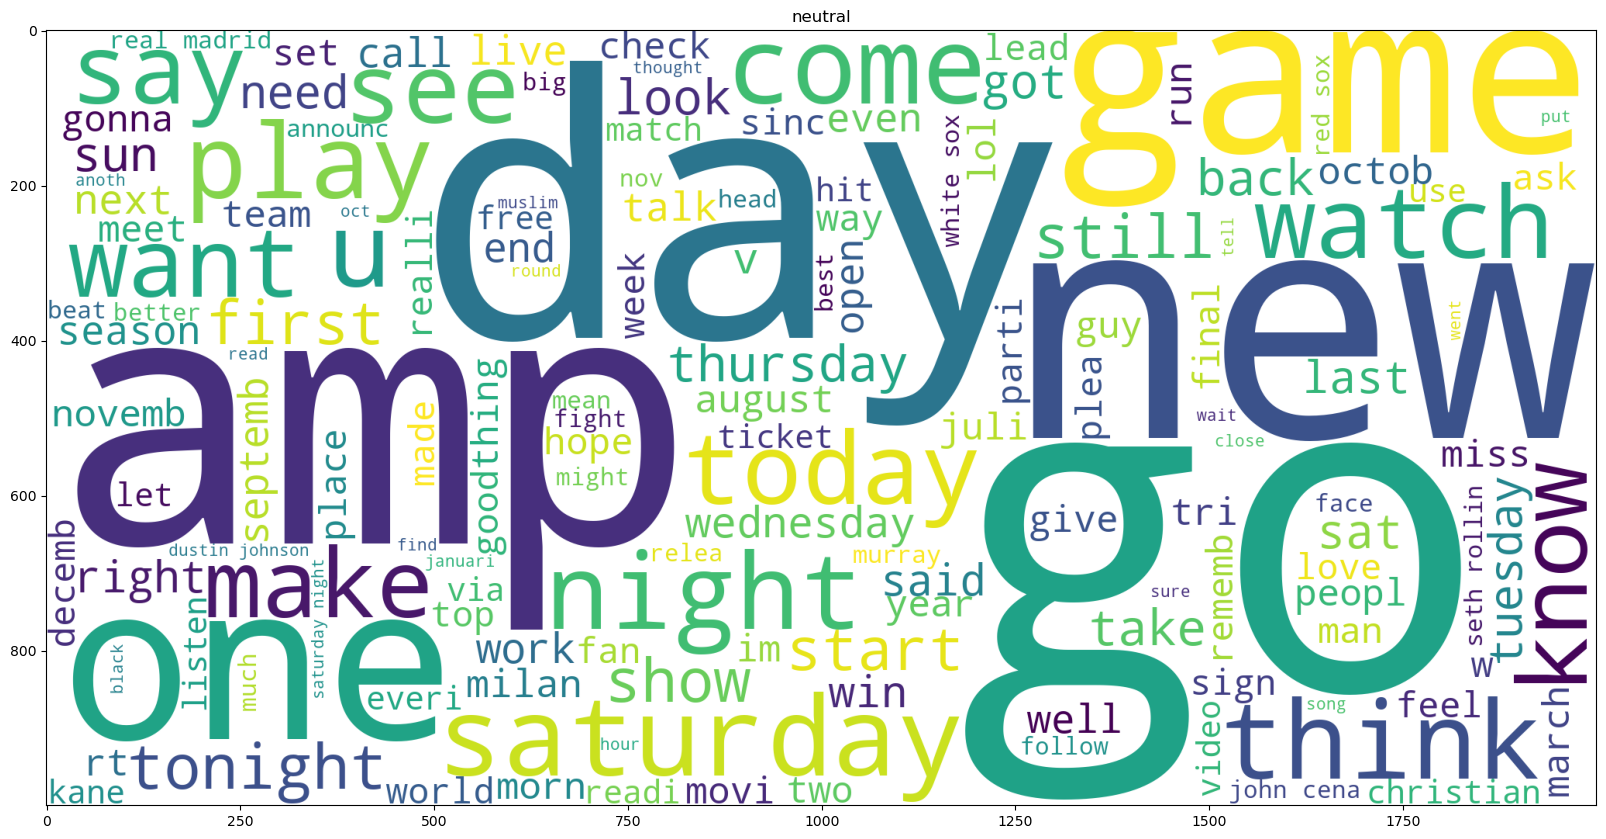

In [31]:
#neutral data
WordCloud()
wordcloud = WordCloud(width=2000,
                      height=1000,
                      background_color='white',
                      max_words = 150).generate(neutral_all)

plt.figure(figsize=(20,30))
plt.imshow(wordcloud)
plt.title("neutral")
plt.show()

l'on remarque dans cette visualisation qu'il y'a repétition des mots pour chaque cas notemment:
* Postif: love, great, best, win, better, etc.
* Negatif: shit, bad, hate, fuck, etc
* Neutre

**Visualisation du nombre d'occurence pour chaque mot**

In [33]:
# fonction qui va compter le nombre d'occurences chaque mot dans les données qu'on lui passe en paramètre
def get_count(data):
    dic = {}
    for i in data:
        for j in i.split():
            if j not in dic:
                dic[j]=1
            else:
                dic[j]+=1    
            
    return(dic)

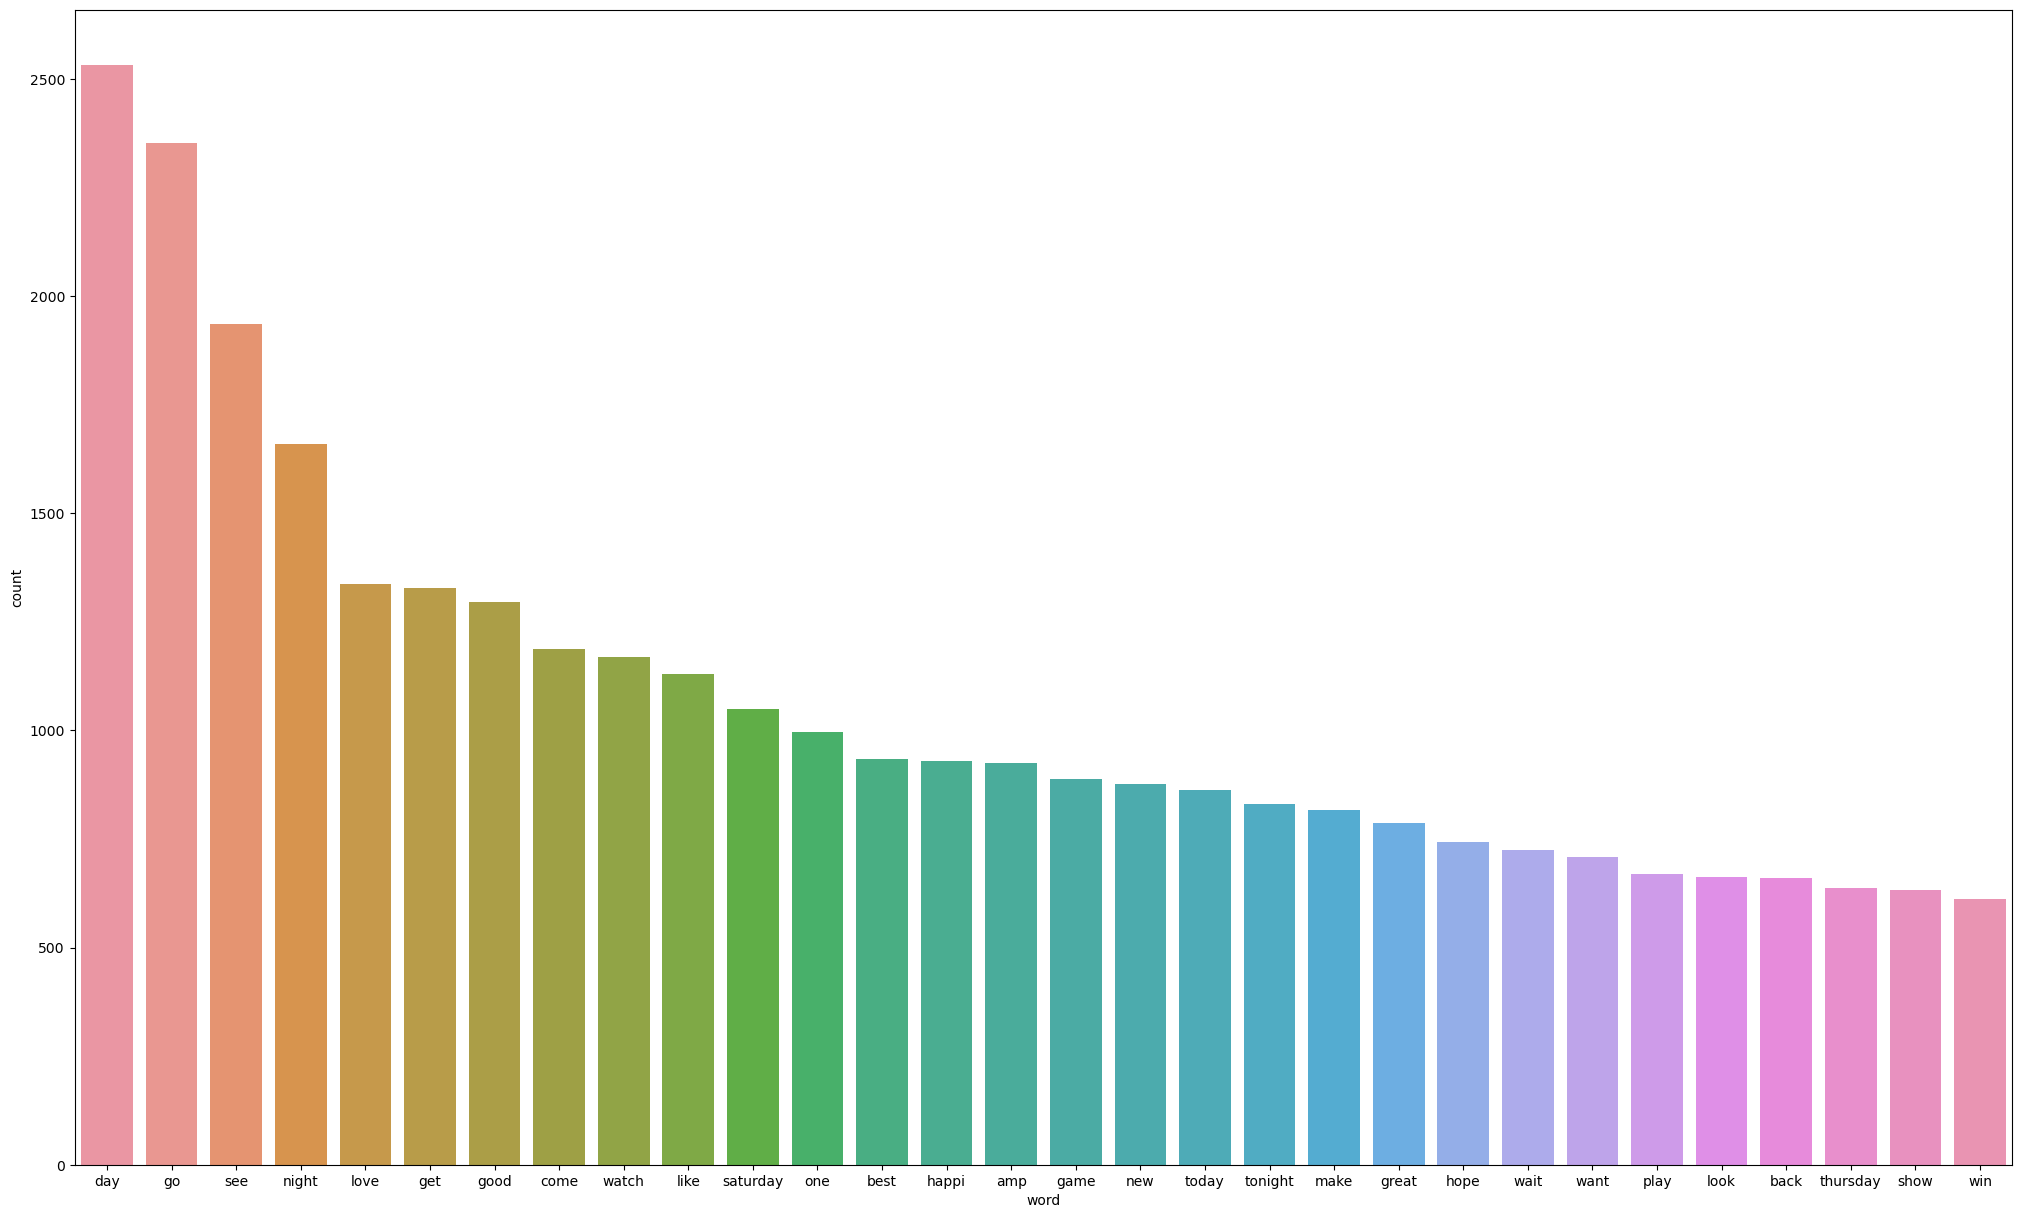

In [34]:
#Positive data
count_corpus = get_count(positive_list)
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

plt.figure(figsize = (25,15))
sns.barplot(x = count_corpus["word"][:30], y = count_corpus["count"][:30])
plt.show()

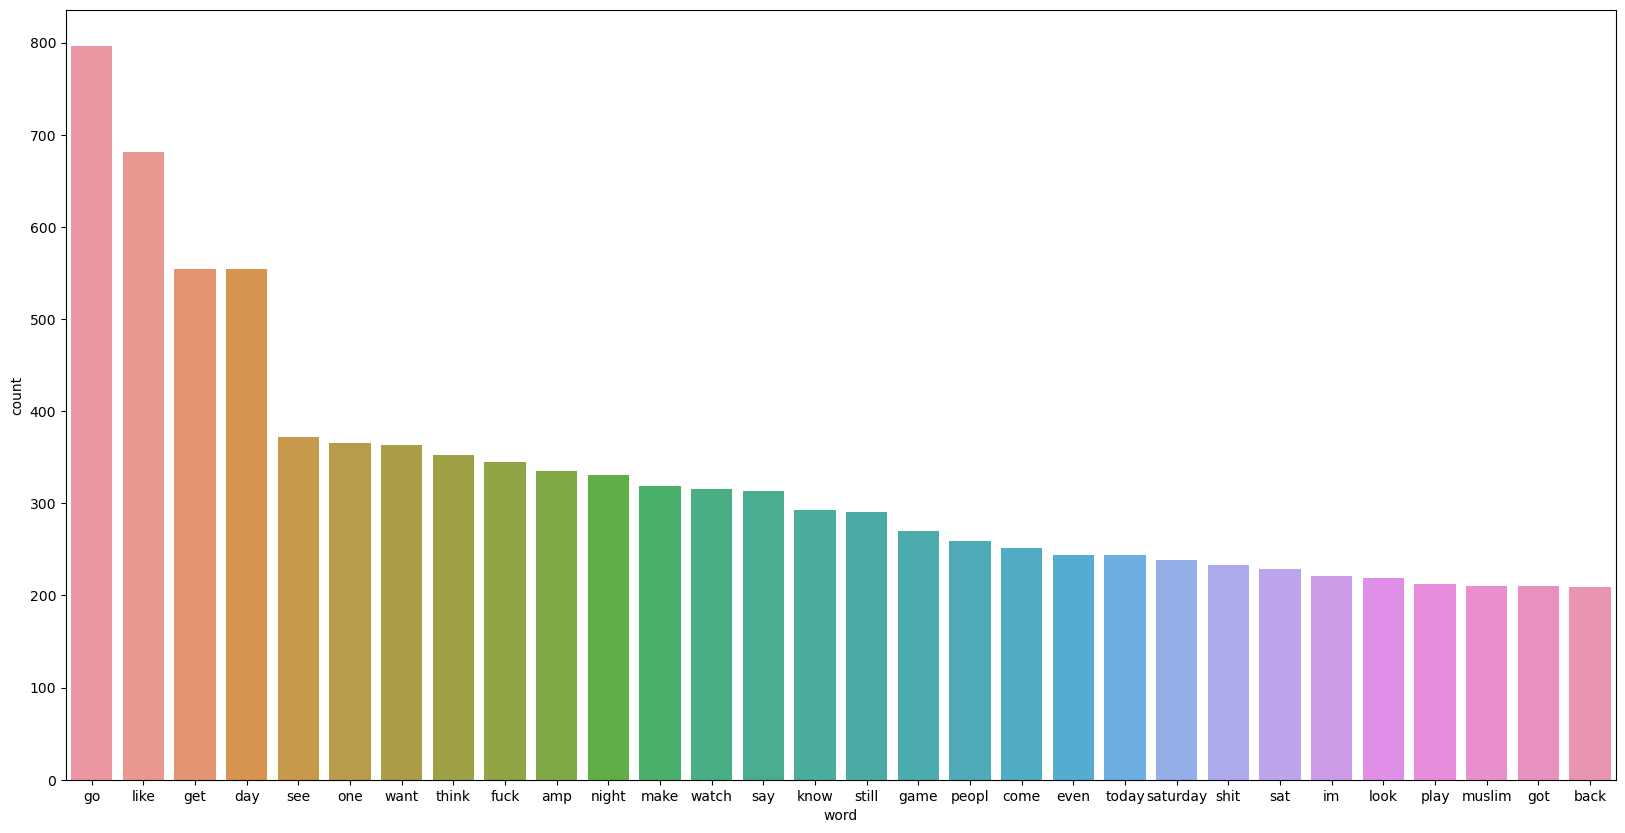

In [35]:
#Negative data
count_corpus = get_count(negative_list)
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

plt.figure(figsize = (20,10))
sns.barplot(x = count_corpus["word"][:30], y = count_corpus["count"][:30])
plt.show()

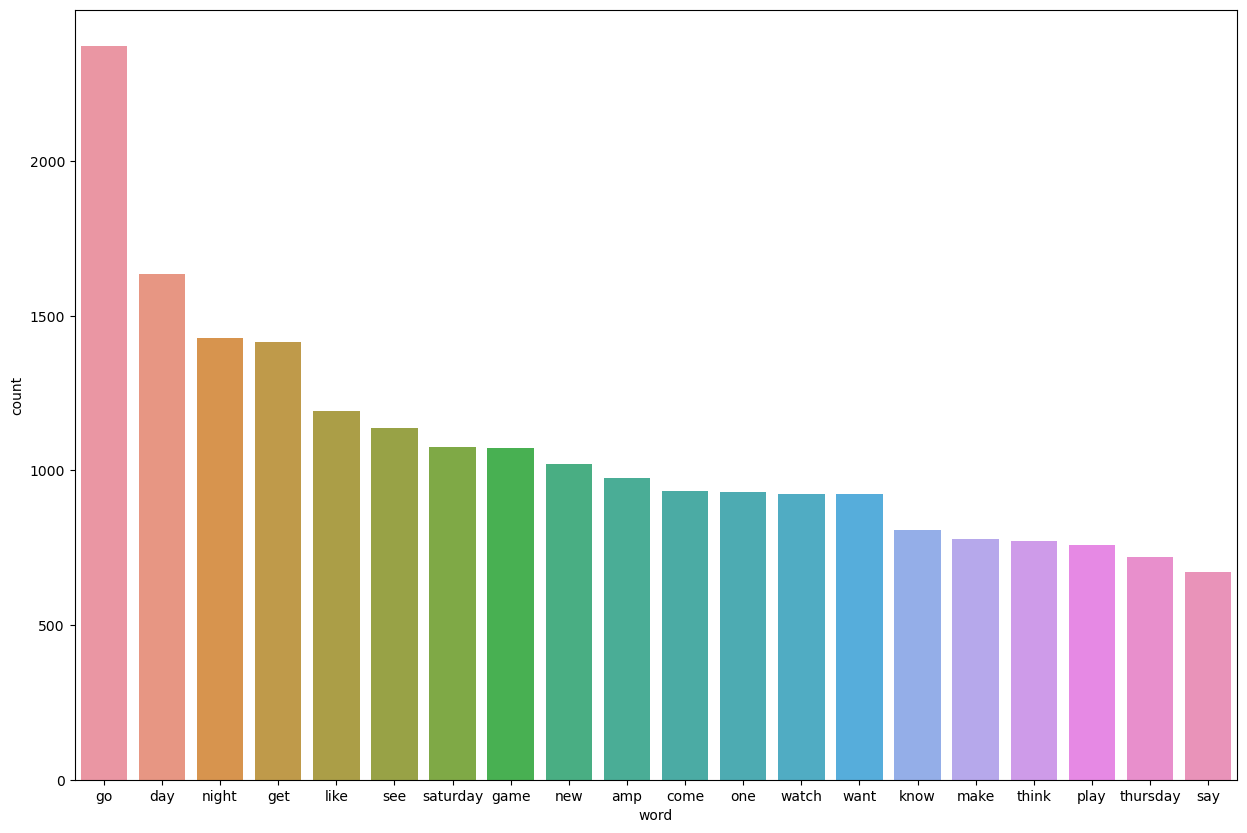

In [36]:
#Neutral data
count_corpus = get_count(neutral_list)
count_corpus = pd.DataFrame({"word":count_corpus.keys(),"count":count_corpus.values()})
count_corpus = count_corpus.sort_values(by = "count", ascending = False)

plt.figure(figsize = (15,10))
sns.barplot(x = count_corpus["word"][:20], y = count_corpus["count"][:20])
plt.show()

## 4. Entraînement du modèle

#### feature enginearing

In [37]:
# chargement des fichiers contenants les mots par type de sentiments
## Ces fichiers peuvent etre telecharger ici:  http://www.cs.uic.edu/~liub/FBS/sentiment-analysis.html
pos_file = open("Other/positive-words.txt","r") 
neg_file = open("Other/negative-words.txt","r")
pos_words = []
neg_words = []
#Each line in positive and negative text file is word + \n
#so i split the line with '\n' to extract the word only
for line in pos_file:
    line = line.split('\n')
    pos_words.append (line[0])
for line in neg_file: 
    line = line.split('\n')
    neg_words.append (line[0])

In [38]:
pos_words

['a+',
 'abound',
 'abounds',
 'abundance',
 'abundant',
 'accessable',
 'accessible',
 'acclaim',
 'acclaimed',
 'acclamation',
 'accolade',
 'accolades',
 'accommodative',
 'accomodative',
 'accomplish',
 'accomplished',
 'accomplishment',
 'accomplishments',
 'accurate',
 'accurately',
 'achievable',
 'achievement',
 'achievements',
 'achievible',
 'acumen',
 'adaptable',
 'adaptive',
 'adequate',
 'adjustable',
 'admirable',
 'admirably',
 'admiration',
 'admire',
 'admirer',
 'admiring',
 'admiringly',
 'adorable',
 'adore',
 'adored',
 'adorer',
 'adoring',
 'adoringly',
 'adroit',
 'adroitly',
 'adulate',
 'adulation',
 'adulatory',
 'advanced',
 'advantage',
 'advantageous',
 'advantageously',
 'advantages',
 'adventuresome',
 'adventurous',
 'advocate',
 'advocated',
 'advocates',
 'affability',
 'affable',
 'affably',
 'affectation',
 'affection',
 'affectionate',
 'affinity',
 'affirm',
 'affirmation',
 'affirmative',
 'affluence',
 'affluent',
 'afford',
 'affordable',
 'af

In [39]:
neg_words

['abnormal',
 'abolish',
 'abominable',
 'abominably',
 'abominate',
 'abomination',
 'abort',
 'aborted',
 'aborts',
 'abrade',
 'abrasive',
 'abrupt',
 'abruptly',
 'abscond',
 'absence',
 'absent-minded',
 'absentee',
 'absurd',
 'absurdity',
 'absurdly',
 'absurdness',
 'abuse',
 'abused',
 'abuses',
 'abusive',
 'abysmal',
 'abysmally',
 'abyss',
 'accidental',
 'accost',
 'accursed',
 'accusation',
 'accusations',
 'accuse',
 'accuses',
 'accusing',
 'accusingly',
 'acerbate',
 'acerbic',
 'acerbically',
 'ache',
 'ached',
 'aches',
 'achey',
 'aching',
 'acrid',
 'acridly',
 'acridness',
 'acrimonious',
 'acrimoniously',
 'acrimony',
 'adamant',
 'adamantly',
 'addict',
 'addicted',
 'addicting',
 'addicts',
 'admonish',
 'admonisher',
 'admonishingly',
 'admonishment',
 'admonition',
 'adulterate',
 'adulterated',
 'adulteration',
 'adulterier',
 'adversarial',
 'adversary',
 'adverse',
 'adversity',
 'afflict',
 'affliction',
 'afflictive',
 'affront',
 'afraid',
 'aggravate',

In [40]:
# pour compter le nombre de mots
def count_words(text):
    text = text.strip()
    list_word = text.split()
    return len(set(list_word))

# pour compter le nombre de mots positifs
def count_positifs_word(text, pos_words=pos_words):
    text = text.strip()
    list = text.split()
    list_pos_word = [word for word in list if word in pos_words]
    return len(list_pos_word)

# pour compter le nombre de mots négatifs
def count_negatifs_word(text, neg_words=neg_words):
    text = text.strip()
    list = text.split()
    list_neg_word = [word for word in list if word in neg_words]
    return len(list_neg_word)

In [41]:
# Nombre de mots par tweet
data["num_unique_words"] = data["cleaned_content"].apply(count_words)
data["num_pos_words"] = data["cleaned_content"].apply(count_positifs_word)
data["num_neg_words"] = data["cleaned_content"].apply(count_negatifs_word)
data.sort_values(by = "num_unique_words", ascending = False)

,id,label,content,cleaned_content,num_unique_words,num_pos_words,num_neg_words
2134,641554268407865345,neutral,All presidents of American except one are or have been related to the Monarchy. David Cameron is...,presid american except one relat monarchi david cameron cousin neutral wed queen alway call davi...,300,10,16
1878,641638563675770881,positive,@106andpark: Did you enjoy last night's Life Of Chris Brown? Next Tuesday we explore the career ...,enjoy last night life chri brown next tuesday explor career treysongz posit wel look like go par...,250,25,15
1829,641436920824901632,positive,@SportsCenter: Serena remains on top! The younger Williams bts Venus in the sisters' 14th GS mat...,sportscent serena remain top younger william bt venu sister gs matchup posit man enough admit pr...,192,30,6
1064,640683262415867905,positive,"Batman may of been the better man in our last encounter, but I'm a man on a mission and it's t...",batman better man last encount man mission expos realli posit heath ledger batman best perform a...,147,11,9
3336,639312236452802561,neutral,"Take the Romans. In the 2nd-3rd centuries BC, the Romans were at war with Hannibal and his army ...",take roman centuri bc roman war hannib armi mercenari posit love thank guy show new hannib fanni...,101,4,3
...,...,...,...,...,...,...,...
17517,672048949671383040,neutral,@jamesastro999 @tryitfirst000 Not just the IRA. https://t.co/MXtt5oPOyu,ira,1,0,0
20337,681298692222136320,neutral,"@mead_n_mjolnir [Wanda sat down where Thor was sitting, while he took Lucas to his room]",mead_n_mjolnir,1,0,0
20426,681491094131970048,neutral,0,,0,0,0
16326,662535951546261504,neutral,[chris Evans is the presenter of TFI Friday and they're being sarcastic in case you don't get Br...,,0,0,0


In [44]:
data.groupby("label").sum()

,id,content,cleaned_content,num_unique_words,num_pos_words,num_neg_words
label,,,,,,
negative,5401765831475764104,@francesco_con40 2nd worst QB. DEFINITELY Tony Romo. The man who likes to share the ball with ev...,worst qb definit toni romo man like share ball everyon includ teamjacquelinemegan im sorri heart...,82890,3356,6525
neutral,-1802947220741300040,Won the match #getin . Plus\u002c tomorrow is a very busy day\u002c with Awareness Day\u2019s an...,match getin plu busi day awar day debat gulp debatarea new england could see first flake season ...,230404,8629,6802
positive,3793231213700553907,Tim Tebow may be availible ! Wow Jerry \u002c what the heck you waiting for ! http://t.co/a7z9FB...,tim tebow avail wow jerri heck waitmariakaykay aga tayo ah good night ce lovelunch new lil spot ...,203531,15278,4814


### 4.1. Séparation du dataset d'entraînement et de test

In [55]:
# Séparation entre les features et les datas
    # selection des features pour l'apprentissage
features = ["cleaned_content", "num_unique_words", "num_pos_words", "num_neg_words"]
df_reduit = data[features]
df_reduit["label"] = data["label"]
df_reduit.head()

,cleaned_content,num_unique_words,num_pos_words,num_neg_words,label
0,match getin plu busi day awar day debat gulp debat,8,0,0,neutral
1,area new england could see first flake season tuesday,9,0,1,neutral
2,worst qb definit toni romo man like share ball everyon includ team,12,1,1,negative
3,thailand washington us presid barack obama vow wednesday visit storm ravag new jersey shore,14,0,0,neutral
4,yll hear toni romo dress halloween giant quaterback caus that could throw night,13,0,0,neutral


In [56]:
y = df_reduit["label"]

In [57]:
#Séparation entre les datasets d'entraînements et de tests
X_train, X_test, y_train, y_test = train_test_split(df_reduit, y, test_size=0.2, random_state=42, stratify = y)
print(f"Train Data Shape: {X_train.shape}\nTest Data Shape: {X_test.shape}")

Train Data Shape: (40105, 5)
Test Data Shape: (10027, 5)


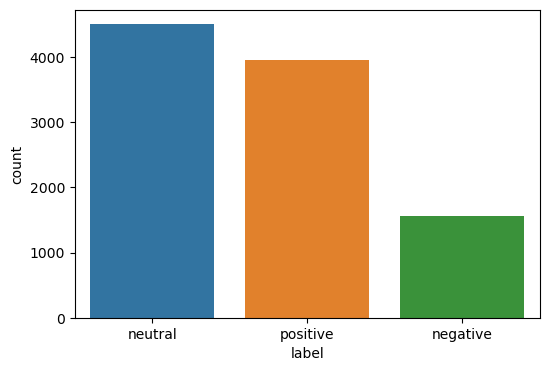

In [58]:
y_test_df = pd.DataFrame(y_test,columns=["label"])
# Barplot describes the count of the class labels
plt.figure(figsize = (6, 4))
sns.countplot(data = y_test_df, x = 'label');

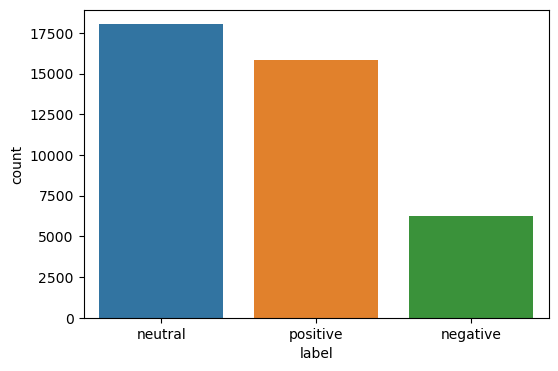

In [59]:
y_train_df = pd.DataFrame(y_train,columns=["label"])
# Barplot describes the count of the class labels
plt.figure(figsize = (6, 4))
sns.countplot(data = y_train_df, x = 'label');

In [60]:
y_train.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

### 4.2. Vectorisation du modèle

In [61]:
le_model = LabelEncoder()
y_train = le_model.fit_transform(y_train)
y_test = le_model.transform(y_test)
le_model.classes_

array(['negative', 'neutral', 'positive'], dtype=object)

In [63]:
from sklearn.feature_extraction.text import TfidfVectorizer
#Vectorisation du train set
tfidf_vectorizer = TfidfVectorizer()
train_vector = tfidf_vectorizer.fit_transform(X_train["cleaned_content"]) # vector est une matrice creuse
other_values = X_train[["num_unique_words", "num_pos_words", "num_neg_words"]].values

# on converti other value en matrice creuse avec scipy
other_values = scipy.sparse._csr.csr_matrix(other_values)
X_train = scipy.sparse.hstack([train_vector, other_values])

In [64]:
#Vectoriser le test set
test_vector = tfidf_vectorizer.transform(X_test["cleaned_content"]) # vector est une matrice creuse
other_values = X_test[["num_unique_words", "num_pos_words", "num_neg_words"]].values

# on converti other value en matrice creuse avec scipy
other_values = scipy.sparse._csr.csr_matrix(other_values)
X_test = scipy.sparse.hstack([test_vector, other_values])

### 4.3 Classification du modèle

In [66]:
def metrics(y_train,y_train_pred,y_test,y_test_pred):
  print("training accuracy = ",round(accuracy_score(y_train,y_train_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_train,y_train_pred)
  print(classification_report(y_train,y_train_pred))
  plt.show()

  print("testing accuracy = ",round(accuracy_score(y_test,y_test_pred),2)*100)
  ConfusionMatrixDisplay.from_predictions(y_test,y_test_pred)
  print(classification_report(y_test,y_test_pred))
  plt.show()

**Entraînement avec la méthode de regression logistic**

training accuracy =  65.0
              precision    recall  f1-score   support

           0       0.70      0.21      0.32      6247
           1       0.61      0.78      0.69     18019
           2       0.70      0.67      0.69     15839

    accuracy                           0.65     40105
   macro avg       0.67      0.56      0.57     40105
weighted avg       0.66      0.65      0.63     40105



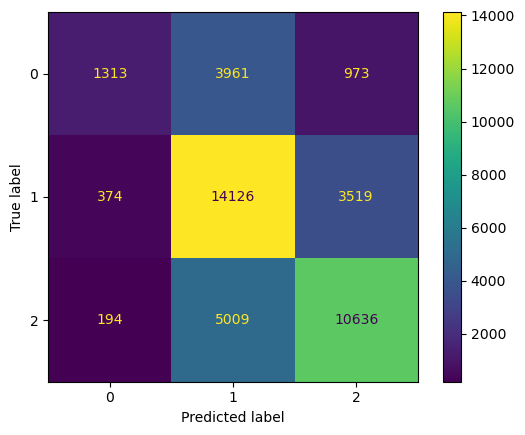

testing accuracy =  63.0
              precision    recall  f1-score   support

           0       0.62      0.20      0.31      1562
           1       0.60      0.74      0.66      4505
           2       0.67      0.67      0.67      3960

    accuracy                           0.63     10027
   macro avg       0.63      0.54      0.55     10027
weighted avg       0.63      0.63      0.61     10027



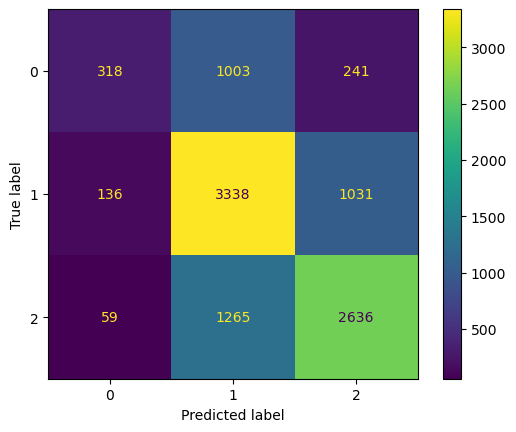

In [67]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

**Entraînement avec la méthode de random forest**

training accuracy =  60.0
              precision    recall  f1-score   support

           0       1.00      0.00      0.00      6247
           1       0.53      0.96      0.69     18019
           2       0.85      0.41      0.56     15839

    accuracy                           0.60     40105
   macro avg       0.80      0.46      0.42     40105
weighted avg       0.73      0.60      0.53     40105



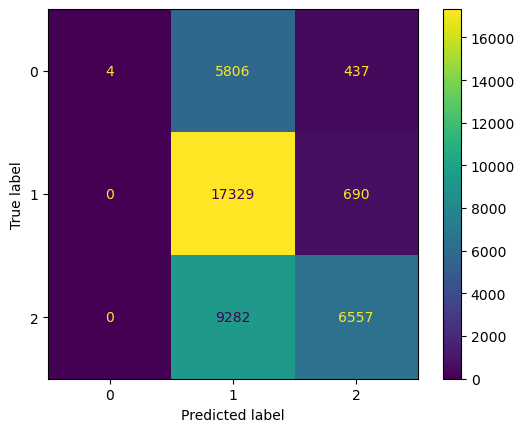

testing accuracy =  57.99999999999999
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1562
           1       0.52      0.94      0.67      4505
           2       0.79      0.40      0.53      3960

    accuracy                           0.58     10027
   macro avg       0.44      0.45      0.40     10027
weighted avg       0.55      0.58      0.51     10027



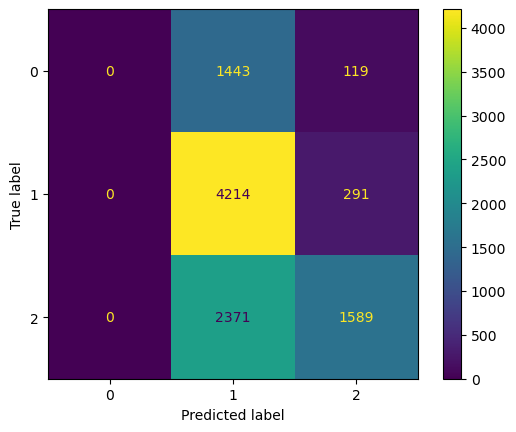

In [68]:
alg_RandomForest = RandomForestClassifier(n_estimators=60, max_depth=20, n_jobs=-1)
rf = alg_RandomForest.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)

**Entraînement avec la méthode Linear SCV**

training accuracy =  89.0
              precision    recall  f1-score   support

           0       0.92      0.82      0.86      6247
           1       0.88      0.91      0.90     18019
           2       0.90      0.90      0.90     15839

    accuracy                           0.89     40105
   macro avg       0.90      0.88      0.89     40105
weighted avg       0.89      0.89      0.89     40105



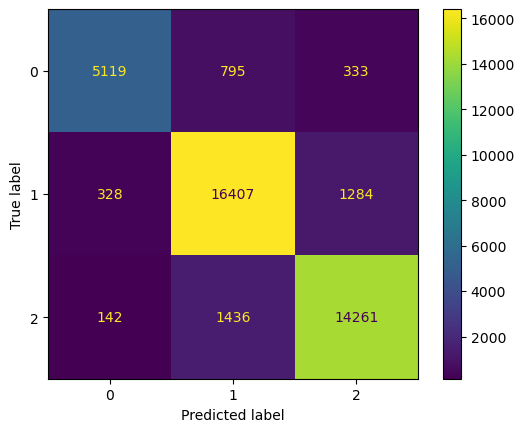

testing accuracy =  65.0
              precision    recall  f1-score   support

           0       0.58      0.45      0.51      1562
           1       0.64      0.70      0.67      4505
           2       0.68      0.68      0.68      3960

    accuracy                           0.65     10027
   macro avg       0.64      0.61      0.62     10027
weighted avg       0.65      0.65      0.65     10027



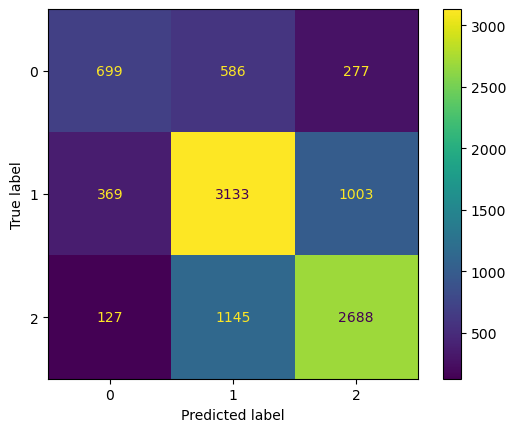

In [70]:
svc = LinearSVC()
svc.fit(X_train,y_train)
y_train_pred = svc.predict(X_train)
y_test_pred = svc.predict(X_test)
metrics(y_train,y_train_pred,y_test,y_test_pred)